# Consigna del trabajo práctico 2

Este trabajo práctico consiste de los siguientes pasos:

1.   Van a recibir dos archivos con datos: train.csv y test4alumnxs.csv, los cuales contienen información sobre accidentes de tránsito en EEUU (más información abajo). La diferencia entre los archivos es que train.csv tiene la columna 'Severity' (severidad) mientras que test4alumnxs.csv no la tiene.
2.   El objetivo es usar los datos para construir un modelo que prediga la severidad del accidente (columna 'Severity', donde 0 es baja severidad y 1 es alta severidad). Para esto, primero pueden usar los datos del archivo train.csv para ajustar los parámetros de su modelo, ajustar los hiperparámetros, combinar los features para agregar nuevos, estandarizar los datos, etc. Al terminar esto, tienen un modelo entrenado en estos datos, y una idea de que tan bien funciona.
3.   Luego, aplican ese modelo a los datos de test4alumnxs.csv y generan un vector de probabilidades que representan la probabilidad de que cada accidente sea severo.
4.   Nosotros tenemos acceso a las etiquetas, así que podemos calcular el AUC de sus predicciones. Con eso construimos un ranking y le damos los siguientes premios al 1er, 2do y 3er puesto.

**Primer puesto:**

"El nudo de la conciencia", autografiado (??) por su autor

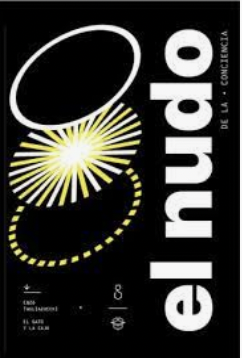

**Segundo puesto:**

"Un libro sobre drogas", autografiado (??) por uno de sus autores

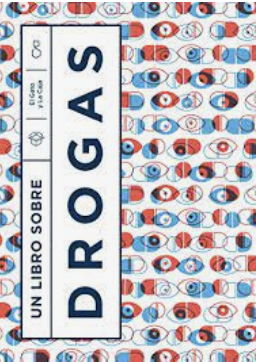

**Tercer puesto:**

"Tabú" 

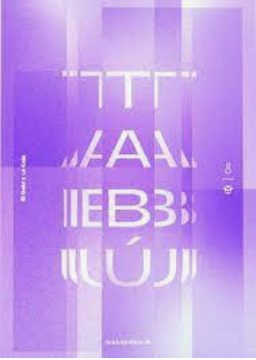



# ¿Cómo se puntua el TP?

**C (0 puntos)**, si no entregan o bien el formato de lo que entregan no es correcto (por ejemplo, la cantidad de probabilidades no es igual a la cantidad de datos en test4alumnxs.csv).

**B (0.5 puntos)**, si entregan y el AUC es menor que 0.7 (más abajo damos un ejemplo donde el auc es 0.73, así que para sacar B tienen que hacer algo que empeore el ejemplo que ya les damos hecho).

**A (1 punto)**, si entregan con un AUC mayor a 0.7.

Recuerden que este TP suma como máximo 1 punto a la nota final de la materia.

# Los datos

Link a los datos: https://drive.google.com/drive/folders/18g4IG96CGvHsWSeLGQJ5gPtFGDpZkdGx?usp=sharing

Los datos corresponden a registros de accidentes de tránsito en EEUU entre 2016 y 2021.

Las primeras dos columnas ("unnamed") no sirve nara nada y se pueden descartar. 

La columna 'Severity' contiene la severidad del accidente (0 significa baja, 1 significa alta)

Luego tenemos la hora de comienzo y final del accidente, la latitud/longitud inicial y final del accidente (entre que valores queda delimitado), la distancia de camino afectada por el accidente, una descripción verbal hecha por un humano, número y nombre de la calle donde ocurrió, lado de la calle (izquierda o derecha), ciudad, condado, estado, código postal, huso horario, código de aeropuerto donde se encuentra la estación meterológica más cercana al accidente, hora en la cual se midió el clima,temperatura, temperatura del viento, humedad, presión, visibilidad, dirección del viento, condición climática (despejado, sol, nieve, etc), presencia de comodidades ("amenities") en la cercanía del accidente, presencia de loma de burro, presencia de un cruce, presencia de señal de ceder paso, presencia de unión de calles, presencia de cartel de no salida, presencia de vías de tren, presencia de rotonda, presencia de estación, presencia de signo de parar, presencia de moderadores de tráfico, presencia de señales de tránsito, presencia de calle en forma de U ("loop"), día u oscuridad de acuerdo a la salida del sol, día u oscuridad de acuerdo a la penumbra civil (si es o no necesario utilizar alumbramiento eléctrico), día u oscuridad de acuerdo a la penumbra náutica, día u oscuridad de acuerdo a la penumbra astronómica.

No todos estos campos son necesariamente útiles, y tampoco no todos están en un formato numérico directamente utilizable (por ejemplo, hay strings en la parte de descripción del accidente). Es parte del trabajo decidir que features quedarse, que features sumar, y como extraer información relevante de los features más complejos. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold,
    KFold,
    cross_validate
)

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline

from joblib import parallel_backend

In [2]:
# run local
filename_train = 'train.csv' 
filename_test = 'test4alumnxs.csv' 

In [3]:
df_train = pd.read_csv(filename_train)
df_test = pd.read_csv(filename_test)

## Clean and explore the dataset

In [4]:
def clean_df(df):
    drop_columns = ['Unnamed: 0', 'Unnamed: 0.1']
    df = df.drop(drop_columns, axis = 1)
    
    df.Start_Time = pd.to_datetime(df.Start_Time )
    df.End_Time = pd.to_datetime(df.End_Time )

    df['Duration(s)']= (df.End_Time - df.Start_Time).dt.total_seconds()

    # df = df.assign(closed_road = lambda df: df.Description.str.contains('Closed'))
    
    print(df.columns)
    
    return df

In [5]:
df_train = clean_df(df_train)
df_test = clean_df(df_test)

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Duration(s)'],
      dtype='object')
Index(['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat',
       'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street', 'Side',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'We

Check if classes are balanced

In [6]:
df_train.Severity.sum()/len(df_train)

0.38752890867041934

The dataset is imbalanced

Pairplot to see if there was any correlated variable

In [7]:
incident_specific_columns = ['Duration(s)','Distance(mi)']

location_columns = ['Number', 'Street','Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code',]

weather_columns = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 
                   'Pressure(in)','Visibility(mi)',  'Wind_Speed(mph)','Precipitation(in)']

traffic_columns = ['Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
                   'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',]

lights_columns = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight']

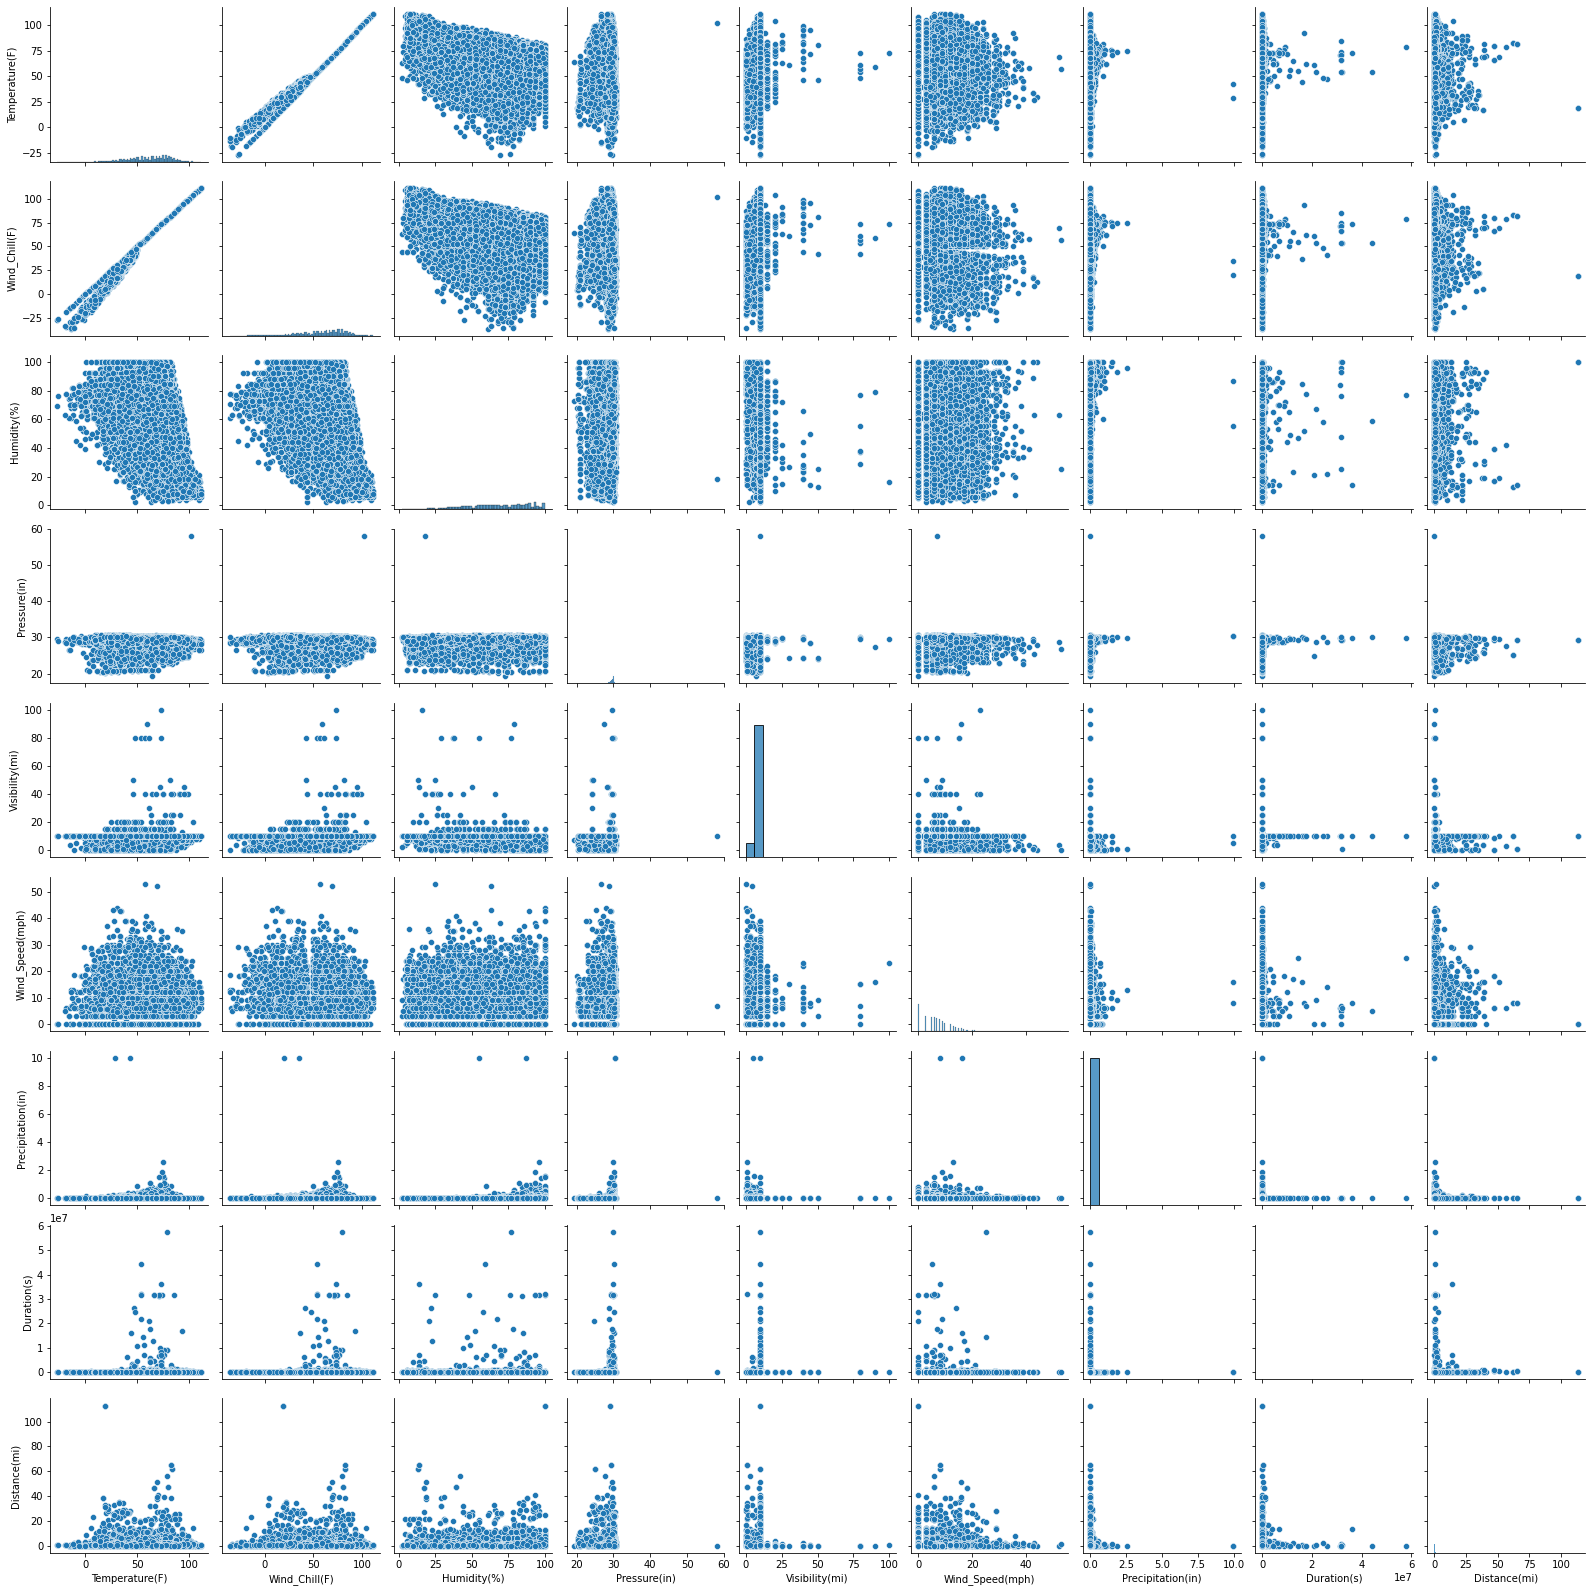

In [8]:
numeric_columns = weather_columns + incident_specific_columns

sns.pairplot(df_train[numeric_columns])

Wind_chill and Temperature are extremely correlated so I will delete Wind_chill

In [9]:
weather_columns.remove('Wind_Chill(F)')

## Prepare dataset for classification

In [22]:
num_cols = incident_specific_columns + weather_columns
text_col = 'Description'

features = num_cols + [text_col] + traffic_columns
X = df_train[features]
X_test = df_test[features]
y = df_train['Severity']

## Model with Randomized Search CV to get the best params

In [17]:

                
cols_trans = ColumnTransformer([
    ('txt', TfidfVectorizer(stop_words={'english'}), text_col),
    ("scaler", StandardScaler(), num_cols),
])

pipe = Pipeline(steps = [('trans', cols_trans),
                ('RF',RandomForestClassifier())]
                )

parameteres = {'RF__bootstrap': [True, False],
                'RF__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                'RF__max_features': ['auto', 'sqrt'],
                'RF__min_samples_leaf': [1, 2, 4],
                'RF__min_samples_split': [2, 5, 10],
                'RF__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

with parallel_backend( 'threading' ):
    grid = RandomizedSearchCV(pipe, param_distributions =parameteres, cv=5, n_jobs=-1)
    grid.fit(X, y)

print(grid.best_params_)



{'RF__n_estimators': 1400, 'RF__min_samples_split': 5, 'RF__min_samples_leaf': 1, 'RF__max_features': 'sqrt', 'RF__max_depth': 100, 'RF__bootstrap': True}


## Model using description

"Description" es la variable que mejor predice las categorías pero en mi opinión es  "trampa" porque casi que dice la gravedad del accidente y explica demasiado la predicción. Igualmente como nada decía que no lo usemos acá está. Y de este modelo entrego las probabilidades. 

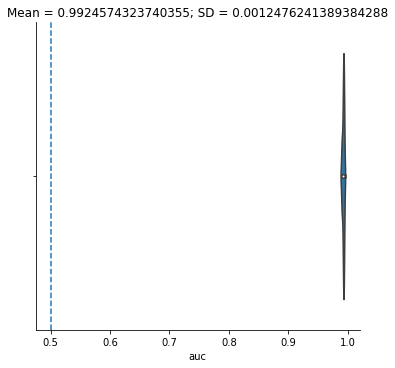

In [18]:
cols_trans = ColumnTransformer([
    ('txt', TfidfVectorizer(stop_words={'english'}), text_col),
    ("scaler", StandardScaler(), num_cols),
])



n_estimators = 1400
min_samples_split =  5
min_samples_leaf= 1
max_features ='sqrt' 
max_depth = 100
bootstrap=True
pipe = Pipeline(steps = [('trans', cols_trans),
                ('Forest',RandomForestClassifier(
                n_estimators=n_estimators, max_features=max_features, criterion='entropy',
                max_depth=max_depth, random_state=42, min_samples_split = min_samples_split, 
                min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
                class_weight=None))]
                )

cv = KFold(5, shuffle=True, random_state = 42)

with parallel_backend( 'threading' ):
    output = cross_validate(
                    X=X, y=y, estimator=pipe,
                    scoring='roc_auc', cv=cv,  n_jobs = -1, return_estimator =True)


aucs = output['test_score']

feature_importances = pd.DataFrame(features, columns = ['features'])
# for idx,estimator in enumerate(output['estimator']):
#     feature_importances[idx] = estimator.named_steps['Forest'].feature_importances_ 

# feature_importances['mean_importance'] = feature_importances.iloc[:, [1,2,3,4,5]].mean(axis=1)
# feature_importances = feature_importances.sort_values('mean_importance', ascending =False)

df_auc = pd.DataFrame(aucs, columns=["auc"])


sns.catplot(x = 'auc', orient = 'h', data = df_auc, kind = 'violin')
plt.title(f'Mean = {np.mean(df_auc.auc)}; SD = {np.std(df_auc.auc)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [20]:
cols_trans = ColumnTransformer([
    ('txt', TfidfVectorizer(stop_words={'english'}), text_col),
    ("scaler", StandardScaler(), num_cols),
])



n_estimators = 1400
min_samples_split =  5
min_samples_leaf= 1
max_features ='sqrt' 
max_depth = 100
bootstrap=True
pipe = Pipeline(steps = [('trans', cols_trans),
                ('Forest',RandomForestClassifier(
                n_estimators=n_estimators, max_features=max_features, criterion='entropy',
                max_depth=max_depth, random_state=42, min_samples_split = min_samples_split, 
                min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
                class_weight=None))]
                )

pipe.fit(X, y)

y_hat = pipe.predict_proba(X)[:, 1]
roc_train = roc_auc_score(y, y_hat)

In [21]:
roc_train

0.9997861275150435

In [23]:
predictions = pipe.predict_proba(X_test)[:, 1] 

print(predictions)

# lo guardo en el espacio de trabajo de colab
np.savetxt('predicciones.csv', predictions, delimiter=",")

[3.46835957e-04 1.46812630e-01 3.15425393e-04 ... 5.10557423e-01
 9.82999168e-01 1.06093350e-02]
